<a href="https://colab.research.google.com/github/ChrisEduS/Volcanic-Events-ML-project/blob/main/MLFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Proyecto de Aprendizaje Automático**
Integrantes: 

*   Christian Santamaría
*   Martin Navarro 00212858
*   Josue Endara 00323096



            



##**INTRODUCCIÓN**:

Ecuador es un país que se encuentra atravesado por una serie de volcanes, varios de ellos
presentan una actividad considerable. El Instituto Geofísico de la EPN ha puesto a disposición
los datos tomados de eventos sísmicos producidos por estos volcanes antes de realizar alguna
actividad. Por medio de aprendizaje supervisado con Machine Learning (Regresión Logística Regularizada y Support Vector Machine), se estimará qué
tipo de actividad volcánica se ha detectado, previniendo así alguna catástrofe o estar atentos
ante eventos poco comunes e importantes de estudiar.

##**DESARROLLO**:

Primero, importaremos las librerías necesarias para la implementación de nuestros modelos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #pd solo es el alias
import os #operating system
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, RepeatedKFold, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, RocCurveDisplay, make_scorer, f1_score, recall_score, precision_score, accuracy_score, roc_auc_score, classification_report
from sklearn.svm import SVC
import seaborn as sns
import json
from joblib import dump, load

In [ ]:
#Ignoring warnings
warnings.filterwarnings('ignore')

Importamos la base de datos desde Google Drive

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Importando la base de datos
id_database = '1Bb2SELv0FmrkNqN2Cl0GWr2GRkMEnGNU'
downloaded = drive.CreateFile({'id':id_database})
downloaded.GetContentFile('Feature_table_clean.csv')  
data = pd.read_csv('Feature_table_clean.csv')

**Solo correr cuando no se desea empezar toda la optimizacion desde cero**

In [ ]:
# Importando GridSearchCV SVM hyper parameter optimization
id_gridsvm = '17cKpVKIbCJDoLkGcyvno7wPfWLrqpLNw'
downloaded = drive.CreateFile({'id':id_gridsvm})
downloaded.GetContentFile('gridsearchRES.joblib')  
svc_search = load('gridsearchRES.joblib')

In [ ]:
# Importando LR best model
id_lrbest = '1q8yg66QxHaYYFHTWFl_1d6lioadu-K_2'
downloaded = drive.CreateFile({'id':id_lrbest})
downloaded.GetContentFile('LR_bestmodel.joblib')  
best_model_LR = load('LR_bestmodel.joblib')

Visualizamos un poco de la base de datos sin ningun tipo de preprocesamiento

In [ ]:
data

,Event_Identifier,Station,Channel,Type,t_mean,t_std,t_var,t_entropy,t_kurtosis,t_multiscaleEntropy,...,w_t_peak2peak_D5,w_t_peak2peak_D6,w_t_peak2rms_A6,w_t_peak2rms_D1,w_t_peak2rms_D2,w_t_peak2rms_D3,w_t_peak2rms_D4,w_t_peak2rms_D5,w_t_peak2rms_D6,w_t_meanEnergyCoeff
0,7e7ea43c735bbfe9e9c1fe73ed97a7e3,BNAS,BHZ,EXPL,-0.035686,0.249026,0.062014,152.217360,4.673847,1.902171,...,0.586886,0.214210,3.526992,4.767929,5.332523,4.040610,3.487185,3.086393,2.744577,0.074095
1,1cc34bbf0bd57cf025c065df41c0f1a1,BNAS,BHZ,EXPL,-0.042388,0.255646,0.065355,149.471451,4.180068,1.790757,...,0.421342,0.137214,1.757422,5.205819,4.271823,4.018401,3.607966,4.349338,2.768516,0.068003
2,d718b9eba8d1d2a1524a4e1e0888d2f8,BNAS,BHZ,EXPL,-0.103105,0.238584,0.056923,150.992826,4.036087,1.840276,...,0.363225,0.141073,1.306040,5.389804,5.227752,4.357040,4.479645,3.081091,3.684229,0.069561
3,3b1ecf423de57ed90c45bdb0194caa60,BNAS,BHZ,EXPL,-0.029458,0.210861,0.044462,108.191907,4.841379,1.799442,...,0.236537,0.087113,1.456827,5.716850,4.151468,3.436199,3.158368,3.396124,2.617087,0.047153
4,1941b6be00dc0edae7b852bfbf1124c3,BNAS,BHZ,EXPL,-0.089604,0.251170,0.063086,165.719234,3.963954,1.839883,...,0.130397,0.085275,1.542586,6.386649,4.776877,3.788521,3.581984,3.180676,2.856925,0.074423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22621,eb099c91c1f418040c6cb2e8e0eb7f9f,BVC2,BHZ,VT,-0.340748,0.167903,0.028191,311.787681,4.336643,2.085717,...,0.083674,0.222785,1.441193,3.514776,4.700277,4.584830,4.780383,3.362945,2.752325,0.192184
22622,193f2b526e7d828a699f455d0bafd631,BVC2,BHZ,VT,-0.184519,0.177459,0.031492,175.515740,5.211110,2.035376,...,0.097236,0.098201,2.023150,4.187169,5.123555,5.046450,4.647142,3.290492,2.767940,0.068537
22623,c10c4844511a0c7970dfdeb94a94c8d7,BVC2,BHZ,VT,-0.027668,0.206155,0.042500,120.643888,5.495223,2.011064,...,0.116974,0.083376,1.581704,4.124492,4.900715,5.298608,4.225148,6.214791,2.440222,0.043550
22624,3a58aa850f9a1212f4e8676cfd4f8665,BVC2,BHZ,VT,0.053860,0.210183,0.044177,112.506469,6.942934,1.653214,...,0.412624,0.189836,2.543642,6.067766,5.363002,5.437774,5.151667,4.247858,3.712399,0.061007


El codigo de importacion de la base de datos se puede ver en [1]

## Visualizacion de datos y Preprocesamiento

Ahora, comprobamos la dimensionalidad de nuesta base de datos aún sin preprocesamiento, ni división en conjuntos de entrenamiento y test. 

In [ ]:
#DIMENSIONALIDAD DE LA BASE DE DATOS

def get_df_size(df, header='Dataset dimensions'):
  print(header,
        '\n# Attributes: ', df.shape[1], 
        '\n# Entries: ', df.shape[0],'\n')
  
get_df_size(data)


Dataset dimensions 
# Attributes:  88 
# Entries:  22626 



Dado que nuestro problema es uno de clasificación multiclase, necesitamos realizar Label Encoding, es decir, transformar nuestros Labels de strings a integeres. A cada clase se le asigna un número desde 0 hasta el número de clases, en nuestro caso, tenemos 10 clases por tanto tendremos las clases 0, 1, 2, ..., 9.

Después de realizar el Label Encoding, quitamos las columnas que no forman parte de nuestras características de entrenamiento.

In [ ]:
#LABEL ENCODING. ASIGNA NUMEROS A LAS CLASES. AUN NO VECTORES
target_names = np.unique(np.array(data['Type']))

labelenc = LabelEncoder()
lbdata = data
lbdata['Type'] = labelenc.fit_transform(lbdata['Type'])

# LIMPIEZA DE BASE DE DATOS ---- SE ELIMINAN CARACTERISTICAS NO NUMERICAS
data_X= data.drop('Type', axis=1)
data_X= data_X.drop('Event_Identifier', axis=1)
data_X= data_X.drop('Station', axis=1)
data_X= data_X.drop('Channel', axis=1)

data_Y = data['Type']

In [ ]:
target_names

array(['EXPL', 'HB', 'LP', 'TRE', 'TREMI', 'TRESP', 'VLP', 'VLP_TYPE1',
       'VLP_TYPE2', 'VT'], dtype=object)

Aquí se visualiza el Label Encoding.

In [ ]:
data_Y

0        0
1        0
2        0
3        0
4        0
        ..
22621    9
22622    9
22623    9
22624    9
22625    9
Name: Type, Length: 22626, dtype: int64

Observemos la distribución de nuestros datos mediante un histograma.

(array([   87.,   533., 11553.,   252.,   712.,   185.,   211.,   205.,
          132.,  8756.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

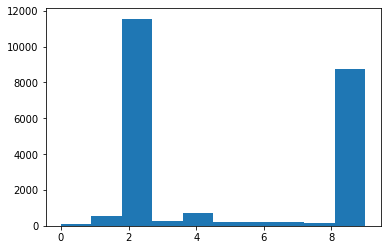

In [ ]:
plt.hist(data_Y)

Como se puede ver, es un dataset imbalanceado. No se realizará ninguna técnica para corregir esto debido a que se desea ver qué comportamiento tendrá a lo largo del proyecto.

Ahora, graficamos la matriz de correlación.

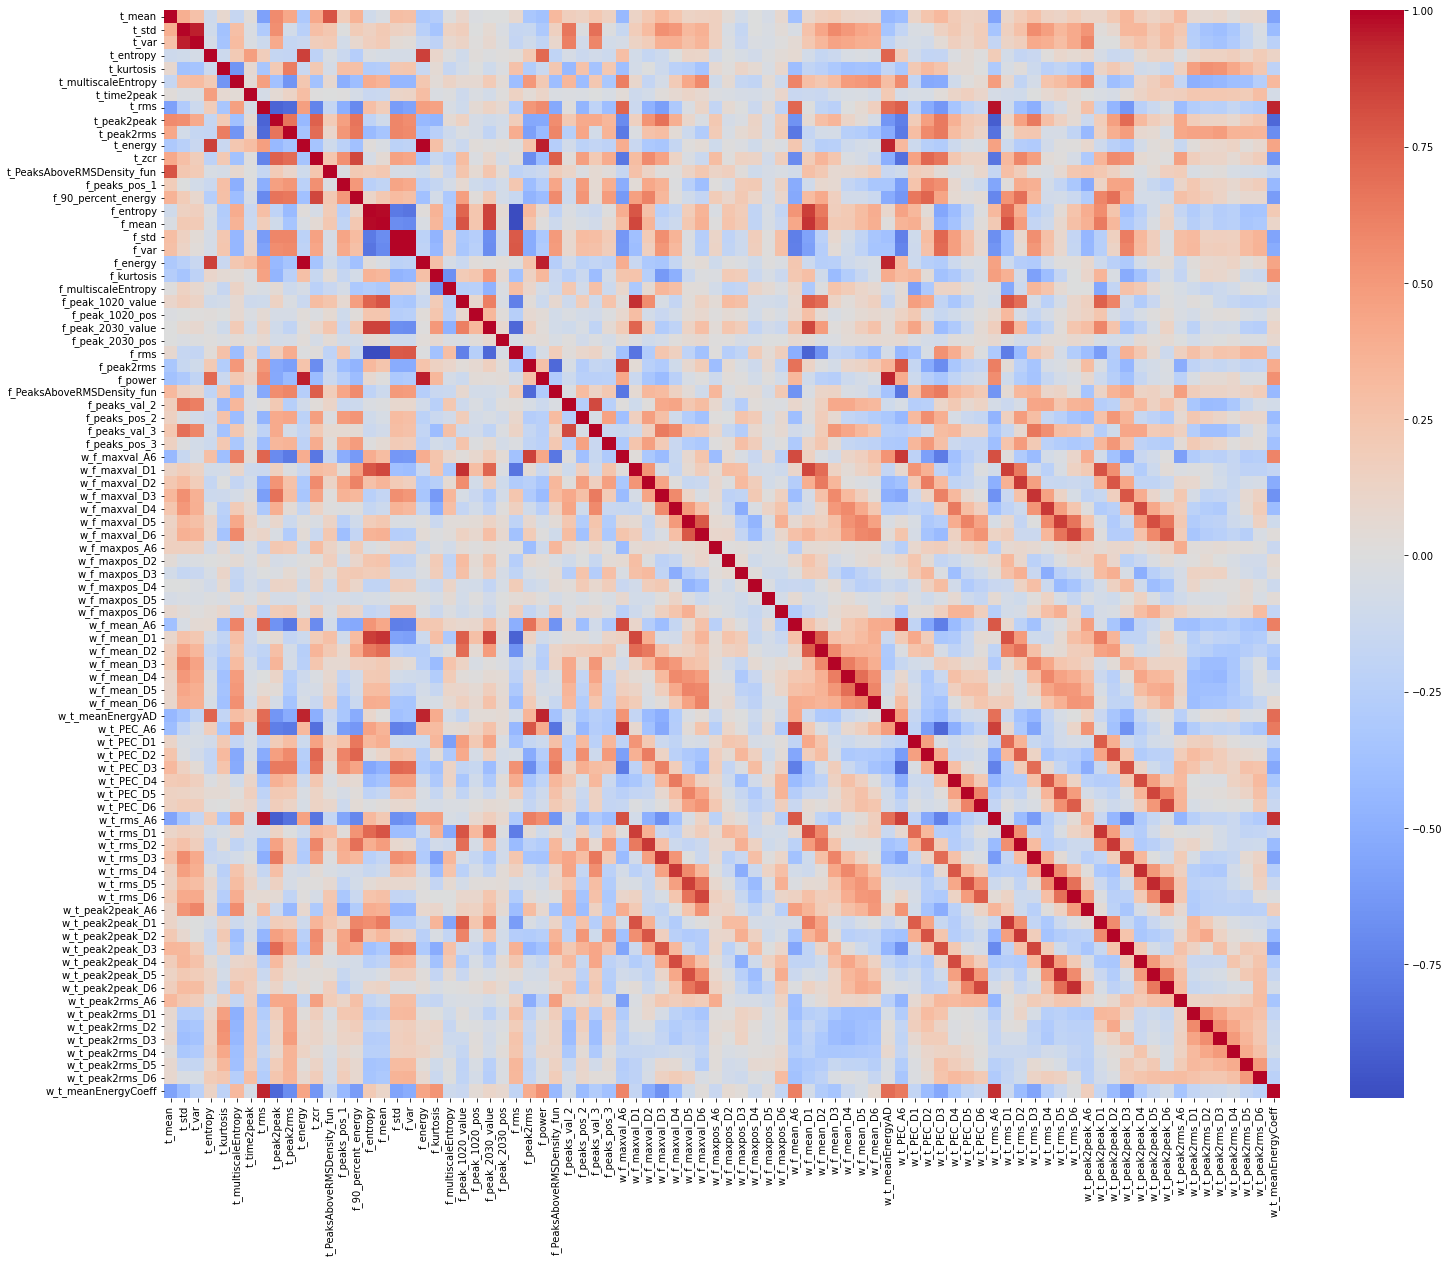

In [ ]:
## CORRELATION MATRIX
fig = plt.figure(figsize=(25, 20))
heatmap_color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(data_X.corr(), annot=None, cmap=heatmap_color)
plt.savefig("corr_mat.png")

Como se observa, la matriz demuestra que ninguna característica está relacionada con otra; por tanto, no podemos eliminarlas. [2] Se debe entrenar los modelos con todas las 84 características.

Después, separamos nuestras muestras en el conjunto de entrenamiento y conjunto de prueba.

In [ ]:
#SEPARACION ENTRENAMIENTO Y PRUEBA
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, stratify=data_Y, test_size=0.2, random_state=123)

print(y_train.shape)
print(y_test.shape)

(18100,)
(4526,)


REGRESIÓN LOGÍSTICA REGULARIZADA

Escalamiento de datos

In [ ]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

Ahora, visualicemos nuestro conjunto de entrenamiento con TSNE. Dado que se tiene 84 características, es un conjunto de alta dimensionalidad, por tanto, primero la reduciremos usando PCA y luego haremos la visualización con TSNE.

[Text(0.5, 1.0, 'TSNE-PCA-VISUALIZATION')]

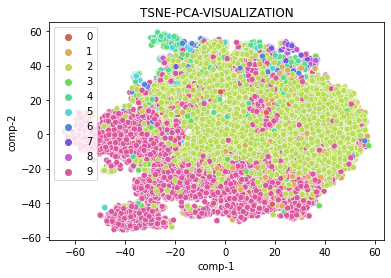

In [ ]:
### DATA VISUALIZATION WITH TSNE
pca = PCA(n_components=50)
pcaR = pca.fit_transform(X_train)

tsne = TSNE(n_components=2, verbose=0, perplexity=50, early_exaggeration=15.0, random_state=123)
tsne_pca_r = tsne.fit_transform(pcaR)

df = pd.DataFrame()
df['y'] = y_train
df['comp-1'] = tsne_pca_r[:,0]
df['comp-2'] = tsne_pca_r[:,1]

sns.scatterplot(x='comp-1', y='comp-2', hue=df.y.tolist(),
                palette=sns.color_palette('hls', 10),
                data=df).set(title="TSNE-PCA-VISUALIZATION")

Durante la realización de Regresión Logística se tuvieron muchos problemas con el uso de la librería GridSearchCV y Pipeline, de igual manera, el tiempo de ejecución era extremadamente largo (8 horas aproximadamente, antes de obtener errores). Por estos motivos, decidimos hacer la optimización del híperparametro C de forma manual con el uso de for loops y StratifiedKFold.

Se utilizaron 3 splits en StratifiedKFold, 4 valores de optimización para C y se realizaron dos repeticiones. Google Colab desconectaba la sesión después de la primera repetición del loop, por tanto decidimos hacerlo en dos bloques diferentes.

**No correr los siguientes bloques de codigo en caso de haber importado los ficheros al inicio del proyecto.**

In [ ]:
## OPTIMIZACION DE PARAMETROS MANUAL (Utilizando For Loops)

c_vals = [0.001, 0.01, 0.1, 1]
logregs_results = [] # List of Logistic Regression Models

stratkfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

f1macro_reps, f1weighted_reps, recall_reps, precision_reps, accuracy_reps = [], [], [], [], []

Primera repetición.

In [ ]:
# 1 --------------------------------------
f1macroC, f1weightedC, recallC, precisionC, accuracyC = [], [], [], [], []
print("Rep: {}".format(1))
for j, c in enumerate(c_vals):
  f1macroKfold, f1weightedKfold, recallKfold, precKfold, accKfold = [], [], [], [], []
  i=1
  for train_index,test_index in stratkfolds.split(X_train,y_train):
    print('{} of StratifiedKFold {}'.format(i, stratkfolds.n_splits))
    xtr,xvl = X_train.iloc[train_index],X_train.iloc[test_index]
    ytr,yvl = y_train.iloc[train_index],y_train.iloc[test_index]
    
    #model
    lrg = LogisticRegression(penalty='l2',
                          C=c,
                          multi_class = 'ovr',
                          solver = 'saga',
                          class_weight='balanced',
                          max_iter=10000)
    lrg.fit(xtr, ytr)
    logregs_results.append(lrg) # saving the model

    #SCORINGS FOR FOLD and SAVING FOR HYPOTESIS TEST
    score = f1_score(yvl, lrg.predict(xvl), average='macro')
    f1macroKfold.append(score)

    score = f1_score(yvl, lrg.predict(xvl), average='weighted')
    f1weightedKfold.append(score)

    score = recall_score(yvl, lrg.predict(xvl), average='macro')
    recallKfold.append(score)

    score = precision_score(yvl, lrg.predict(xvl), average='macro')
    precKfold.append(score)

    score = accuracy_score(yvl, lrg.predict(xvl))
    accKfold.append(score)

    i+=1

  # SCORINGS FOR HYPERPARAMETER
  f1macroC.append(np.mean(f1macroKfold))

  f1weightedC.append(np.mean(f1weightedKfold))

  recallC.append(np.mean(recallKfold))

  precisionC.append(np.mean(precKfold))

  accuracyC.append(np.mean(accKfold))


  print("C = {}".format(c))
  print("Macro f1 score: {}".format(f1macroC[j]))
  print("weighted f1 score: {}".format(f1weightedC[j]))
  print("Recall: {}".format(recallC[j]))
  print("Precision: {}".format(precisionC[j]))
  print("Accuracy: {}".format(accuracyC[j]))
  print()

#SCORING FOR REPETITION
f1macro_reps.append(max(f1macroC))
f1weighted_reps.append(max(f1weightedC))
recall_reps.append(max(recallC))
precision_reps.append(max(precisionC))
accuracy_reps.append(max(accuracyC))

Rep: 1
1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 0.001
Macro f1 score: 0.39240808815614175
weighted f1 score: 0.7804603853419257
Recall: 0.5037741530327565
Precision: 0.40980819225757875
Accuracy: 0.7481766811099333

1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 0.01
Macro f1 score: 0.41397221239198534
weighted f1 score: 0.7968651938118324
Recall: 0.5168762322171723
Precision: 0.4161669689493283
Accuracy: 0.7678450857410892

1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 0.1
Macro f1 score: 0.4353908622922132
weighted f1 score: 0.8057150902347799
Recall: 0.5371057310497451
Precision: 0.4243034567998673
Accuracy: 0.7775687938706649

1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 1
Macro f1 score: 0.4387731548710419
weighted f1 score: 0.8063535620280587
Recall: 0.5362010957174721
Precision: 0.42270865281084835
Accuracy: 0.7788394724313298



Segunda Repetición

In [ ]:
# 2 ----------------------------------
f1macroC, f1weightedC, recallC, precisionC, accuracyC = [], [], [], [], []
print("Rep: {}".format(2))
for j, c in enumerate(c_vals):
  f1macroKfold, f1weightedKfold, recallKfold, precKfold, accKfold = [], [], [], [], []
  i=1
  for train_index,test_index in stratkfolds.split(X_train,y_train):
    print('{} of StratifiedKFold {}'.format(i, stratkfolds.n_splits))
    xtr,xvl = X_train.iloc[train_index],X_train.iloc[test_index]
    ytr,yvl = y_train.iloc[train_index],y_train.iloc[test_index]
    
    #model
    lrg = LogisticRegression(penalty='l2',
                          C=c,
                          multi_class = 'ovr',
                          solver = 'saga',
                          class_weight='balanced',
                          max_iter=10000)
    lrg.fit(xtr, ytr)
    logregs_results.append(lrg) # saving the model

    #SCORINGS FOR FOLD and SAVING FOR HYPOTESIS TEST
    score = f1_score(yvl, lrg.predict(xvl), average='macro')
    f1macroKfold.append(score)

    score = f1_score(yvl, lrg.predict(xvl), average='weighted')
    f1weightedKfold.append(score)

    score = recall_score(yvl, lrg.predict(xvl), average='macro')
    recallKfold.append(score)

    score = precision_score(yvl, lrg.predict(xvl), average='macro')
    precKfold.append(score)

    score = accuracy_score(yvl, lrg.predict(xvl))
    accKfold.append(score)

    i+=1

  # SCORINGS FOR HYPERPARAMETER
  f1macroC.append(np.mean(f1macroKfold))
  f1weightedC.append(np.mean(f1weightedKfold))
  recallC.append(np.mean(recallKfold))
  precisionC.append(np.mean(precKfold))
  accuracyC.append(np.mean(accKfold))

  print("C = {}".format(c))
  print("Macro f1 score: {}".format(f1macroC[j]))
  print("weighted f1 score: {}".format(f1weightedC[j]))
  print("Recall: {}".format(recallC[j]))
  print("Precision: {}".format(precisionC[j]))
  print("Accuracy: {}".format(accuracyC[j]))
  print()

#SCORING FOR REPETITION
f1macro_reps.append(max(f1macroC))
f1weighted_reps.append(max(f1weightedC))
recall_reps.append(max(recallC))
precision_reps.append(max(precisionC))
accuracy_reps.append(max(accuracyC))

Rep: 2
1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 0.001
Macro f1 score: 0.39240808815614175
weighted f1 score: 0.7804603853419257
Recall: 0.5037741530327565
Precision: 0.40980819225757875
Accuracy: 0.7481766811099333

1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 0.01
Macro f1 score: 0.41397221239198534
weighted f1 score: 0.7968651938118324
Recall: 0.5168762322171723
Precision: 0.4161669689493283
Accuracy: 0.7678450857410892

1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 0.1
Macro f1 score: 0.4353908622922132
weighted f1 score: 0.8057150902347799
Recall: 0.5371057310497451
Precision: 0.4243034567998673
Accuracy: 0.7775687938706649

1 of StratifiedKFold 3
2 of StratifiedKFold 3
3 of StratifiedKFold 3
C = 1
Macro f1 score: 0.4388022122182014
weighted f1 score: 0.8063904940106289
Recall: 0.5362119147156329
Precision: 0.4227304010421064
Accuracy: 0.7788947241026928



Después de realizar la optimización manual, procedemos a hallar el mejor modelo obtenido considerando la métrica wheighted f1 score debido a que, como se mencionó anteriormente, nuestro data set es imbalanceado, por tanto, es importante considerar la distribucion de los labels.

In [ ]:
# Hallando el mejor modelo
best_C = c_vals[f1weighted_reps.index(max(f1weighted_reps))]
print(best_C)

0.01


Fit del mejor modelo con C = 0.01

In [ ]:
# Fit mejor modelo
best_model_LR = LogisticRegression(penalty='l2',
                           C=best_C,
                           multi_class = 'ovr',
                           solver = 'saga',
                           class_weight='balanced',
                           max_iter=10000)
best_model_LR.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=10000,
                   multi_class='ovr', solver='saga')

Guardando el mejor modelo.

In [ ]:
dump(best_model_LR, 'LR_bestmodel.joblib')

['LR_bestmodel.joblib']

**Es posible correr desde aqui**

Calculando las métricas solicitadas.

In [ ]:
# PERFORMANCE del mejor modelo
y_predict_test = best_model_LR.predict(X_test)
print("Macro F1 Score: ", f1_score(y_test, y_predict_test, average='macro')) 
print("weighted F1 Score: ", f1_score(y_test, y_predict_test, average='weighted')) 
print("Recall Score: ", recall_score(y_test, y_predict_test, average='macro')) 
print("Precision Score: ", precision_score(y_test, y_predict_test, average='macro')) 
print("Accuracy Score: ", accuracy_score(y_test, y_predict_test)) 

Macro F1 Score:  0.4558653250765995
weighted F1 Score:  0.8091968969859148
Recall Score:  0.5962512899287465
Precision Score:  0.4465435069373968
Accuracy Score:  0.7799381352187362


Curva de aprendizaje

training error: 0.9057109557109555 test error: 0.6649010951190163 subset size: 20
training error: 0.9329931972789117 test error: 0.685289144026752 subset size: 28
training error: 0.8671510119356513 test error: 0.7193791086495991 subset size: 41
training error: 0.7727067838629705 test error: 0.7044140849836228 subset size: 58
training error: 0.830661748267382 test error: 0.7231337244065219 subset size: 84
training error: 0.787029887029887 test error: 0.6805037433675927 subset size: 120
training error: 0.8055804550868175 test error: 0.7323882573088168 subset size: 172
training error: 0.7291703160460942 test error: 0.6557005536665338 subset size: 246
training error: 0.8435665204674044 test error: 0.7627660978212865 subset size: 352
training error: 0.8289892952697844 test error: 0.767321792974128 subset size: 504
training error: 0.813356529520384 test error: 0.7739802028705931 subset size: 721
training error: 0.7991567299254341 test error: 0.7785764626049899 subset size: 1031
training erro

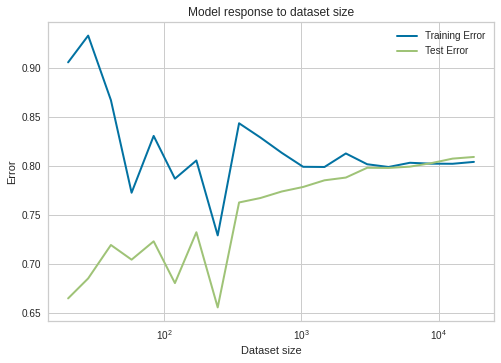

In [ ]:
from numpy.ma.extras import average
def data_size_response(model,trX,teX,trY,teY,score_func,prob=True,n_subsets=20):

    train_errs,test_errs = [],[]
    subset_sizes = np.exp(np.linspace(3,np.log(trX.shape[0]),n_subsets)).astype(int)

    for m in subset_sizes:
        model.fit(trX[:m],trY[:m])
        if prob:
            train_err = score_func(trY[:m],model.predict(trX[:m]), average='weighted')
            test_err = score_func(teY,model.predict(teX), average='weighted')
        else:
            train_err = score_func(trY[:m],model.predict(trX[:m]), average='weighted')
            test_err = score_func(teY,model.predict(teX), average='weighted')
        print("training error: {} test error: {} subset size: {}".format(train_err,test_err,m))
        train_errs.append(train_err)
        test_errs.append(test_err)

    return subset_sizes,train_errs,test_errs

def plot_response(subset_sizes,train_errs,test_errs):

    plt.plot(subset_sizes,train_errs,lw=2)
    plt.plot(subset_sizes,test_errs,lw=2)
    plt.legend(['Training Error','Test Error'])
    plt.xscale('log')
    plt.xlabel('Dataset size')
    plt.ylabel('Error')
    plt.title('Model response to dataset size')
    plt.show()

LRscore_func = f1_score
LRresponse = data_size_response(best_model_LR,X_train,X_test,y_train,y_test,LRscore_func,prob=True)
plot_response(*LRresponse)

Referencia del codigo en [3]

Curvas ROC

In [ ]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):
    enco = {key:val for (key, val) in enumerate(target_names)}
    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder=enco)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

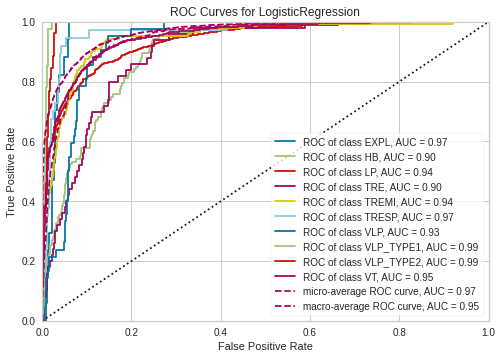

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0477f4af0>,
       encoder={0: 'EXPL', 1: 'HB', 2: 'LP', 3: 'TRE', 4: 'TREMI', 5: 'TRESP',
                6: 'VLP', 7: 'VLP_TYPE1', 8: 'VLP_TYPE2', 9: 'VT'},
       estimator=LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=10000, multi_class='ovr',
                                    solver='saga'))

In [ ]:
plot_ROC_curve(best_model_LR, X_train, y_train, X_test, y_test)

Referencia del codigo en [4]

## SUPPORT VECTOR MACHINE (CLASSIFICATION)

Ahora, realizaremos el mismo procedimiento pero utilizando una técinca diferente de ML: Support Vector Machine.
Nuevamente, separamos las muestras en entrenamiento y test.

In [ ]:
#SEPARACION ENTRENAMIENTO, VALIDACION Y PRUEBA
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, stratify=data_Y, test_size=0.2, random_state=123)

print(y_train.shape)
print(y_test.shape)

(18100,)
(4526,)


En el siguiente bloque de código, se realiza la optimización de híperparametros usando Pipeline, una librería que nos ayuda a manejar el workflow de nuestro programa, es decir, automatiza procesos de Standarization, Reducción de dimensionalidad, y aplicación de modelo a nuestros conjuntos de entrenamiento y prueba. [5] Para la optimización de los hiperparametros C y gamma se utiliza GridSearchCV y comprobamos el mejoramiento del modelo utilizando la metrica wheighted f1 score (refit).

**No correr el siguiente bloque de codigo en caso de haber importado los ficheros al inicio del proyecto.**

In [ ]:
#SVM (MULTICLASE)
#Using Pipeline, and setting hyperparameters for optimization

#Pipeline steps. 1. Standarization, 2. Dimensionality reduction, 3. ML Model to be used
pipe = Pipeline([
                  ('scaler', StandardScaler()),
                  ('reduce_dim', PCA(n_components=0.9)),
                  ('classifier', SVC(kernel='rbf',max_iter=-1, class_weight='balanced')) 
])

grid_param = {'classifier__C': [0.001, 0.01, 0.1, 1, 10],
            'classifier__gamma': [0.001,0.01,0.1,1,10]}

# Defining StratifiedKFold
cvSKF = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=123)
#Scoring arguments. Saving scorings of each iteration.
scoringv = {"accuracy": make_scorer(accuracy_score),
           "recall": make_scorer(recall_score, average='macro'),
           "precision": make_scorer(precision_score, average='macro'),
           "f1_weighted": make_scorer(f1_score, average="weighted"),
           "f1_macro": make_scorer(f1_score, average="macro")
           }
#Hyper-parameter optimization
svc_search = GridSearchCV(pipe, grid_param, cv=cvSKF, scoring=scoringv, refit='f1_weighted', error_score='raise') #refit param used for eval the optimization iters
svc_search.fit(X_train, y_train)


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=123),
             error_score='raise',
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', PCA(n_components=0.9)),
                                       ('classifier',
                                        SVC(class_weight='balanced'))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10],
                         'classifier__gamma': [0.001, 0.01, 0.1, 1, 10]},
             refit='f1_weighted',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_macro': make_scorer(f1_score, average=macro),
                      'f1_weighted': make_scorer(f1_score, average=weighted),
                      'precision': make_scorer(precision_score, average=macro),
                      'recall': make_scorer(recall_score, average=macro)})

In [ ]:
# Guardando el resultado del GridSearchCV
dump(svc_search, 'gridSearchRES.joblib')

['gridSearchRES.joblib']

Resultaldos de la optimizacion de hiper parametros con GridSearchCV

In [ ]:
svc_search.cv_results_

{'mean_fit_time': array([56.80873191, 58.08466832, 58.94442805, 53.99523811, 53.44462486,
        53.36261423, 43.3662103 , 58.76564689, 54.2185243 , 53.61163775,
        30.91771428, 21.78142504, 51.00981406, 54.47630505, 53.79439946,
        18.40610743, 11.5759575 , 31.68575879, 57.32603137, 58.02139926,
        11.95526254,  7.16825541, 38.32382441, 86.8770326 , 92.28400743]),
 'std_fit_time': array([2.19398838, 0.47129554, 0.37338451, 0.35129315, 0.31453275,
        0.43448245, 0.56410658, 0.29907006, 0.87060621, 0.54176032,
        0.18657157, 0.34706128, 0.34524146, 0.34353892, 0.43556809,
        0.37467855, 0.07723106, 0.35787493, 0.1799392 , 0.38738634,
        0.13358405, 0.07625623, 0.39174901, 4.26147889, 4.1987472 ]),
 'mean_score_time': array([7.65662154, 7.59155258, 7.59100918, 7.7506599 , 8.33653816,
        7.67646662, 7.53784116, 7.5803109 , 7.81159945, 8.13651172,
        6.87473385, 5.98073522, 7.28226415, 7.53132157, 8.09776314,
        5.66840796, 4.64962784, 5.7

¿Cuales fueron los mejores hiperparametros?

In [ ]:
# Mejores hiperparamteros
svc_search.best_params_

{'classifier__C': 10, 'classifier__gamma': 0.01}

Ahora realizamos el fit del modelo SVM con los mejores hiperparametros encontrados

In [ ]:
# Escalamiento
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

In [ ]:
best_model_SVC = SVC(C=10, gamma=0.01, kernel='rbf',max_iter=-1, class_weight='balanced')
best_model_SVC.fit(X_train, y_train)

SVC(C=10, class_weight='balanced', gamma=0.01)

Desplegamos las metricas solicitadas.

In [ ]:
# PERFORMANCE del mejor modelo
y_predict_test = best_model_SVC.predict(X_test)
print("Macro F1 Score: ", f1_score(y_test, y_predict_test, average='macro')) 
print("weighted F1 Score: ", f1_score(y_test, y_predict_test, average='weighted')) 
print("Recall Score: ", recall_score(y_test, y_predict_test, average='macro')) 
print("Precision Score: ", precision_score(y_test, y_predict_test, average='macro')) 
print("Accuracy Score: ", accuracy_score(y_test, y_predict_test)) 

Macro F1 Score:  0.6295673625080012
weighted F1 Score:  0.8706267008345645
Recall Score:  0.6394705269893849
Precision Score:  0.628046282576269
Accuracy Score:  0.8694211224038887


Curva de aprendizaje

training error: 1.0 test error: 0.6332310450557659 subset size: 20
training error: 1.0 test error: 0.6689652628940692 subset size: 28
training error: 1.0 test error: 0.7100331033794598 subset size: 41
training error: 1.0 test error: 0.734442754840168 subset size: 58
training error: 1.0 test error: 0.7431823967405704 subset size: 84
training error: 0.9916770342723422 test error: 0.7474594382251807 subset size: 120
training error: 0.9883990526791676 test error: 0.7690239508864349 subset size: 172
training error: 0.9797174782939231 test error: 0.775723439483051 subset size: 246
training error: 0.9716267257771164 test error: 0.779732157508896 subset size: 352
training error: 0.9742391196123179 test error: 0.7829893513530138 subset size: 504
training error: 0.9583691382805655 test error: 0.7970833071269918 subset size: 721
training error: 0.9505299675334147 test error: 0.8138718958466759 subset size: 1031
training error: 0.9458154502568393 test error: 0.8272771821163593 subset size: 1475
tr

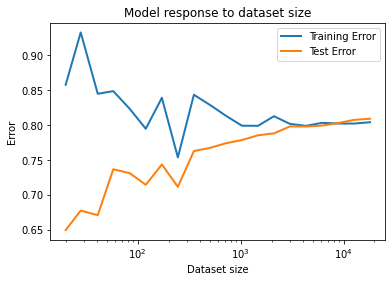

In [ ]:
SVCscore_func = f1_score
SVCresponse = data_size_response(best_model_SVC,X_train,X_test,y_train,y_test,SVCscore_func,prob=True)
plot_response(*LRresponse)

Curvas ROC

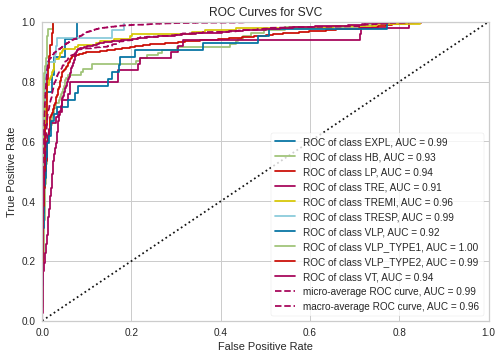

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc04918c310>,
       encoder={0: 'EXPL', 1: 'HB', 2: 'LP', 3: 'TRE', 4: 'TREMI', 5: 'TRESP',
                6: 'VLP', 7: 'VLP_TYPE1', 8: 'VLP_TYPE2', 9: 'VT'},
       estimator=SVC(C=10, class_weight='balanced', gamma=0.01))

In [ ]:
plot_ROC_curve(best_model_SVC, X_train, y_train, X_test, y_test)

###Prueba de Hipotesis

**Hipotesis nula**:\
No existe diferencia significativa entre las medias del weighted-f1 score obtenidos de los modelos de LogisticRegression y Support Vector Machine.\
**Hipotesis alternativa:**\
La media de los weighted f1 score obtenida durante la optimizacion del modelo de LogisticRegression presenta una diferencia significativa con respecto a la media de los weighted f1 score obtenida durante la optimizacion de Support Vector Machine.


In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv

t, p = paired_ttest_5x2cv(estimator1=best_model_LR ,estimator2=best_model_SVC,
                          X=X_train, y=y_train, scoring=make_scorer(f1_score, average="weighted"))
alpha = 0.05

print('t statistic: {}'.format(t))
print('aplha ', alpha)
print('p value: {}'.format(p))

if p > alpha:
  print("Fail to reject null hypotesis")
else:
  print("Reject null hypotesis")

t statistic: -16.35445659992334
aplha  0.05
p value: 1.5591279879179613e-05
Reject null hypotesis


## Conclusiones

Despues de haber optimizado los respectivos hiperparametros de las tecnicas de Machine Learning: Logistic Regression, Support Vector Machine con el uso de la metrica weighted F1, obtuvimos los mejores modelos. Estos, a su vez, nos entregaron los siguientes resultados a la hora de realizar las predicciones.
  1. LogisticRegression.\
  weighted F1 Score:  0.8091968969859148
  2. Support Vector Machine.\
  weighted F1 Score:  0.8706267008345645

Como se observa, realmente se consiguieron metricas similares lo que nos dio un indicio de que el performance de los modelos no eran significativamente diferentes.

Ante la suposicion anterior, planteamos nuestra hipotesis nula estableciendo que los performance de las tecnicas eran similares, mientras que la alternativa afirma que si existe una diferencia significativa.\
Despues de llevar a cabo nuestra prueba de hipotesis con un valor para alfa de 0.05, obtuvimos un resultado que nos llevo a rechazar, de forma contundente, la hipotesis nula; por tanto, concluimos que los performances de las tecnicas de Machine Learning utilizadas son significativamente diferentes.

## Observaciones

Support Vector Machine tuvo un tiempo de ejecucion durante la optimizacion considerablemente mas rapido que Logistic Regression, esto puede deberse a que SVM se basa en las propiedades geométricas de los datos, mientras que la regresión logística se basa en enfoques estadísticos.[6]\
Como se menciono, SVM presento una metrica de weighted f1 score mejor que LogisticRegression, esto se debe a que SVM intenta encontrar el "mejor" margen (distancia entre la línea y los vectores de soporte) que separa las clases y esto reduce el riesgo de error en los datos, mientras que la regresión logística no lo hace, sino que puede tener diferentes límites de decisión con diferentes pesos. que están cerca del punto óptimo.[6]

##Referecias

[1] A. Apte. (2018, Nov 27). Get Started: 3 Ways to Load CSV files into Colab. [Online]. Available: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92#:~:text=To%20start%2C%20log%20into%20your,Colab%20has%20it%20installed%20already).

[2] P. Morales. (2011). El coeficiente de correlacion. [Online]. Available: https://ice.unizar.es/sites/ice.unizar.es/files/users/leteo/materiales/01._documento_1_correlaciones.pdf

[3] Newmu. (2014, Feb 17). How to graph Learning Curve of Logistic Regression?. [Online]. Available: https://stackoverflow.com/questions/21819953/how-to-graph-learning-curve-of-logistic-regression

[4] V. DiFrancesco. (2021, Feb 2). How to Create an AUC ROC Plot for a Multiclass Model. [Online]. Available: https://medium.com/swlh/how-to-create-an-auc-roc-plot-for-a-multiclass-model-9e13838dd3de#:~:text=For%20multiclass%20problems%2C%20ROC%20curves,calculated%20for%20each%20class%20individually

[5] A. Kanumuru. (2021, Aug 15). Scikit-learn Pipeline Tutorial with Parameter Tuning and Cross-Validation. [Online]. Available: https://towardsdatascience.com/scikit-learn-pipeline-tutorial-with-parameter-tuning-and-cross-validation-e5b8280c01fb

P. Bassey. (2019, Sep 19). Logistic Regression Vs Support Vector Machines (SVM). [Online]. Available: https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16